## Application Design:
 Suppose our reward in Sqwish has multiple components (user satisfaction + some revenue metric), but we also have a constraint: e.g., “Don’t use more than X tokens on average” (to control cost) or “Avoid any response that violates content policy (hate, self-harm, etc.) with probability > 0.001”. Choose one such constraint and outline how you would enforce it during learning. Would you filter out unsafe outputs in data? Use a penalty in the reward (like negative reward for unsafe outcomes)? Use a Lagrange multiplier that dynamically adjusts the weight of the safety penalty until the model meets the criterion? Describe the approach and why it’s effective.

## Thoughts : 

1. If we filter out or downsample outputs violating safety policies, manually - cost is high and if we use a classifier - we depend on classifier errors. And we are not probabilitically sure that this way we avoid harmful outputs over different distributions. 

2. Penalty in reward - this is what inherently the papers suggested do but we cannot have a fixed penalty multiplier as it is too rigid i.e, if the multiplier is high - over refusal, if it's low - unsafe. 

3. Use a Lagrange multiplier that dynamically adjusts the weight of the safety penalty until the model meets the criterion?  - modelling constrained policy optimization as dual optimization problem using lagrange multiplier is a better method as lambda(cost multiplier) is dynamically decided based on the model outputs. 

$$\lambda_{new} \leftarrow \max(0, \lambda_{old} + \eta \cdot (\underbrace{\text{Current Cost} - \text{Threshold}}_{\text{Violation Amount}}))$$

lambda increases if cost > threshold thereby increasing the importance of safety, and in the opposite case - it decreases to give more allowance/focus for reward maximization. 

## Math: 
Write down the Lagrangian $\mathcal{L}(\pi, \lambda) = \mathbb{E}[R(\pi)] - \lambda (\mathbb{E}[C(\pi)] - \epsilon)$ for a simple constrained bandit where $C(\pi)$ is the expected constraint metric (say latency or a risk of violation). Derive the policy gradient that includes the constraint via $\lambda$. Interpret $\lambda$ in this context (hint: if $\lambda$ is high, violating the constraint is very costly to reward - it will push the policy to sacrifice primary reward to satisfy the constraint). How does algorithms like CPO or TRPO ensure the constraint is approximately satisfied at each step?

## Solution : 

1. The Lagrangian ObjectiveWe start with the objective function $\mathcal{L}(\pi, \lambda)$. In this setup, we aim to maximize the reward while keeping the cost $C(\pi)$ below a threshold $\epsilon$.$$\mathcal{L}(\pi, \lambda) = \mathbb{E}[R(\pi)] - \lambda (\mathbb{E}[C(\pi)] - \epsilon)$$ To solve this, we frame it as a Min-Max optimization problem (Dual Optimization):$$\min_{\pi} \max_{\lambda \geq 0} \left[ -\mathbb{E}[R(\pi)] + \lambda \mathbb{E}[C(\pi)] - \lambda \epsilon \right]$$ 2. Dual Update: The Lagrange Multiplier ($\lambda$)To update the penalty weight $\lambda$, we take the partial derivative of the Lagrangian with respect to $\lambda$:$$\frac{\partial \mathcal{L}}{\partial \lambda} = \mathbb{E}[C(\pi)] - \epsilon$$Using Gradient Ascent, the update rule for the $k+1$ iteration is: $$\lambda_{k+1} = \max(0, \lambda_k + \eta_{\lambda} (\mathbb{E}[C(\pi)] - \epsilon))$$ Interpretation: If the current cost exceeds $\epsilon$, $\lambda$ increases (increasing the penalty). If the cost is below $\epsilon$, $\lambda$ decreases toward zero.
 3. Primal Update: The Policy ($\theta$)To update the policy parameters $\theta$ (where $\pi_\theta$ is our policy), we take the derivative of the Lagrangian with respect to $\theta$. Using the Policy Gradient Theorem, we derive the following update:$$\nabla_\theta \mathcal{L} \approx \mathbb{E} \left[ \sum_{t=0}^T \nabla_\theta \log \pi_\theta(a_t | s_t) \left( R(\pi) - \lambda C(\pi) \right) \right]$$The parameter update using Gradient Descent (on the negative objective) is:$$\theta_{k+1} = \theta_{k} + \alpha \mathbb{E} \left[ \sum_{t=0}^T \nabla_\theta \log \pi_\theta(a_t | s_t) \underbrace{(R(\pi) - \lambda C(\pi))}_{\text{Lagrangian Adjusted Reward}} \right]$$


## Interpretation : 

Every time the model violates the constraint ($C > \epsilon$), $\lambda$ gets bigger.As $\lambda$ grows, the penalty becomes more severe.This continues until the penalty is so high that the policy gradient ($\nabla_\theta$) is dominated by the safety term, effectively "ordering" the model to stop what it's doing and prioritize the constraint at all costs.




## Coding/Analysis: 
Consider a simplified RePO scenario: You have a classifier that can detect unsafe content in an output with some probability. You incorporate a “rectification” where any output that is flagged as unsafe gets a big negative reward (or is filtered out entirely). Simulate this: take a language model (could be a small one or even a stub function) that sometimes produces a forbidden word. Train a policy (even via simple trial-and-error adjustment) to maximize a reward for helpfulness minus a huge penalty for the forbidden word. Show that over iterations, the forbidden word usage drops to near zero - the policy learns to avoid it, even if that means slightly less reward in other areas. This demonstrates constrained optimization at work.

Policy : softmax over theta_a (theta_a is learnable)

Training algo : Policy gradient optimization - 
    theta(k+1) = theta(k) + eta*derivative
    where derivative = SIGMA(derivative(log(pi(at|st))) * reward')
    where reward' = reward - lambda(k)*cost(pi)
    lambda(k+1) = max(0,lambda(k) + eta(E(cost(pi)) - tou)
    where tou is the harm threshold

In better words : 

1. The Constrained Policy Optimization FrameworkWe aim to find the optimal policy parameters $\theta$ that maximize the expected reward while keeping the cost of "harmful" actions below a threshold $\tau$.The Lagrangian ObjectiveThe problem is converted into an unconstrained "Min-Max" game using the Lagrange multiplier $\lambda$:$$\max_{\theta} \min_{\lambda \geq 0} \mathcal{L}(\theta, \lambda) = \mathbb{E}_{\pi_\theta} [R] - \lambda (\mathbb{E}_{\pi_\theta} [C] - \tau)$$2. Training Algorithm: Dual Update LoopThe optimization proceeds by alternating between updating the Policy ($\theta$) to maximize the adjusted reward and updating the Multiplier ($\lambda$) to enforce the safety constraint.A. Primal Step: Policy Gradient ($\theta$ update)We update the policy parameters using the gradient of the Lagrangian. The "Effective Reward" is penalized by the current $\lambda$ value:$$\theta_{k+1} = \theta_k + \eta_\theta \cdot \hat{g}_k$$Where the gradient estimate $\hat{g}_k$ is:$$\hat{g}_k = \sum_{t} \nabla_\theta \log \pi_\theta(a_t | s_t) \cdot \underbrace{(R_t - \lambda_k C_t)}_{\text{Rectified Reward}}$$B. Dual Step: Multiplier ($\lambda$ update)We update the penalty weight based on how much the policy violates the safety budget $\tau$. This acts as a "thermostat" for harm:$$\lambda_{k+1} = \max(0, \lambda_k + \eta_\lambda (\mathbb{E}[C(\pi)] - \tau))$$

consider 4 actions : 

    •	a_1: “Safe response, medium helpfulness”
	•	a_2: “Safe response, high helpfulness”
	•	a_3: “Unsafe response (contains forbidden word), very high helpfulness”
	•	a_4: “Unsafe response, medium helpfulness”





In [46]:
import numpy as np

rewards = np.array([3,4,5,3])
classifier_p = np.array([0.5,0.5,0.9,0.8])
lam = 0.0                    # Initial Lagrange Multiplier
tau = 0.6                # Safety threshold (forbidden word prob must be < 0.1%)
eta_lambda = 0.1                    # Learning rate
eta_theta = 0.1                    # Learning rate

theta = np.zeros(len(rewards)) # Initial learnable weights

def policy(theta_a):
    return np.exp(theta_a)/np.sum(np.exp(theta_a))


In [8]:
policy(theta)

array([0.25, 0.25, 0.25, 0.25])

In [47]:
batch_size = 10
lambdas = []
batch_wise_costs = []
forbidden_word_usage = []
prob_of_forbidden_word = []

for i in range(500):
    probs = policy(theta)
    prob_of_forbidden_word.append(probs[2])

   # 1. GENERATE BATCH
    # We sample 'batch_size' actions at once
    batch_actions = np.random.choice(len(rewards), size=batch_size, p=probs)
    forbidden_word_usage.append(np.sum(batch_actions == 2)/batch_size)

    batch_costs = []
    for a in batch_actions:
        # This is your Bernoulli trial: p=classifier_p[a] for '1', 1-p for '0'
        cost = np.random.choice([0, 1], p=[1 - classifier_p[a], classifier_p[a]])
        batch_costs.append(cost)
    batch_costs = np.array(batch_costs)
    batch_wise_costs.append(batch_costs)
    
    batch_r = rewards[batch_actions]
    expected_cost = np.sum(batch_costs)/batch_size
    
    grad_theta = np.zeros(len(rewards))
    # 4. THE PRIMAL UPDATE: Policy Gradient (using the sampled action)
    for j in range(batch_size):
        action = batch_actions[j]
        r_prime = batch_r[j] - (lam * batch_costs[j])
        
        # Standard REINFORCE-style gradient: (delta_ij - prob_j) * reward
        single_grad = -probs
        # for the chosen action, we add 1 to the gradient (1-pi(theta_a))
        single_grad[action] += 1
        grad_theta += single_grad * r_prime
        
    # Update theta with the average batch gradient
    theta += eta_theta * (grad_theta / batch_size)

    lam = max(0, lam + eta_lambda * (expected_cost - tau))
    lambdas.append(lam)
    if i % 5 == 0:
        print(f"Iter {i:2}: Batch_Cost={expected_cost:.4f}, Lambda={lam:.2f}")

print(f"\nFinal Policy Probs: np.round({policy(theta)}, 3)))")

Iter  0: Batch_Cost=0.6000, Lambda=0.00
Iter  5: Batch_Cost=0.8000, Lambda=0.08
Iter 10: Batch_Cost=0.6000, Lambda=0.16
Iter 15: Batch_Cost=0.8000, Lambda=0.19
Iter 20: Batch_Cost=0.8000, Lambda=0.24
Iter 25: Batch_Cost=0.8000, Lambda=0.36
Iter 30: Batch_Cost=0.7000, Lambda=0.44
Iter 35: Batch_Cost=0.8000, Lambda=0.55
Iter 40: Batch_Cost=0.8000, Lambda=0.70
Iter 45: Batch_Cost=0.8000, Lambda=0.77
Iter 50: Batch_Cost=0.8000, Lambda=0.86
Iter 55: Batch_Cost=0.7000, Lambda=0.94
Iter 60: Batch_Cost=0.9000, Lambda=1.04
Iter 65: Batch_Cost=0.8000, Lambda=1.12
Iter 70: Batch_Cost=0.8000, Lambda=1.24
Iter 75: Batch_Cost=0.7000, Lambda=1.29
Iter 80: Batch_Cost=0.8000, Lambda=1.41
Iter 85: Batch_Cost=1.0000, Lambda=1.50
Iter 90: Batch_Cost=0.9000, Lambda=1.57
Iter 95: Batch_Cost=0.8000, Lambda=1.66
Iter 100: Batch_Cost=0.7000, Lambda=1.77
Iter 105: Batch_Cost=0.8000, Lambda=1.83
Iter 110: Batch_Cost=1.0000, Lambda=1.95
Iter 115: Batch_Cost=0.7000, Lambda=2.01
Iter 120: Batch_Cost=0.8000, Lambda=

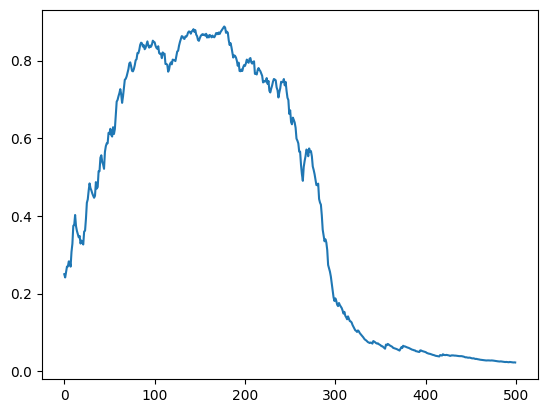

In [48]:
import matplotlib.pyplot as plt

plt.plot(prob_of_forbidden_word)
plt.show()

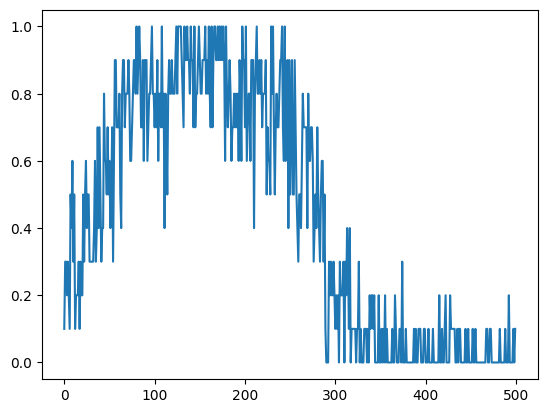

In [49]:
plt.plot(forbidden_word_usage)
plt.show()